# Setup: Import Packages
We also read in the data. 

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, roc_auc_score
)                           
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree

#import pygeos
import rtree
import shapely
import pyproj
import geopandas
import seaborn as sns
from collections import Counter

In [89]:
#read in all the data, create copy of main df
df = pd.read_csv("NYC Accidents 2020 Cleanedish.csv")
coords = df[["LATITUDE", "LONGITUDE"]]
boro_polys = geopandas.GeoDataFrame.from_file("borough.shp")

#get the coordinates into the right shape 
# coords["geometry"] = coords.apply(lambda row: shapely.geometry.Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)
# #put coordinates into geodata frame
# boro_points = geopandas.GeoDataFrame(coords['geometry'], geometry="geometry")
# #makr sure coordinate systems match between coordinates and polygons
# boro_points.crs = boro_polys.crs
# #do the join
# boro_result = geopandas.tools.sjoin(boro_points, boro_polys, how="left") #this is same number of rows as df, so we can just add the column

# df["borough"] = boro_result["boro_name"]

CRSError: Invalid projection: epsg:4326: (Internal Proj Error: proj_create: SQLite error on SELECT name, type, coordinate_system_auth_name, coordinate_system_code, datum_auth_name, datum_code, area_of_use_auth_name, area_of_use_code, text_definition, deprecated FROM geodetic_crs WHERE auth_name = ? AND code = ?: no such column: area_of_use_auth_name)

# Data Cleaning / Wrangling

Other steps for processing the data, making it ready for analysis, involve one-hot encoding the categorical "vehicle types" and "contributing factors" variables; creating a variable for the month of year and hour of day of the accident; and formally encoding the binary indicator of whether physical injury, including death, occurred in the accident. We also split the data into training, validation, and test sets. 

In [13]:
#code for cleaning the vehicle type variable
def combine(lst):
    cleaned = [x for x in lst if x]
    return " --- ".join(cleaned)

car_types_df = df[["VEHICLE TYPE CODE 1",
                    "VEHICLE TYPE CODE 2",
                    "VEHICLE TYPE CODE 3",
                    "VEHICLE TYPE CODE 4",
                    "VEHICLE TYPE CODE 5"]]
car_types_df = car_types_df.fillna("")
car_types_lst = np.sort(car_types_df.values, axis = 1)
car_types_lst = list(map(combine, car_types_lst))

#get the most common car-type combinations
count = Counter()
for typ in car_types_lst: 
    count[typ] += 1
common = count.most_common(20)
type_set = set([k for k, v in common])
car_types_lst_topped = [x if x in type_set else "OTHER" for x in car_types_lst]

assert(len(set(car_types_lst_topped)) == 21)
df["VEHICLE TYPES"] = car_types_lst_topped
#drop the separate vehicle-type variables, now that we have the combined version
df = df.drop(["VEHICLE TYPE CODE 1",
                "VEHICLE TYPE CODE 2",
                "VEHICLE TYPE CODE 3",
                "VEHICLE TYPE CODE 4",
                "VEHICLE TYPE CODE 5"], axis = 1)

#do the one-hot encoding of the vehicle type variable
dummies_vehicles = pd.get_dummies(df["VEHICLE TYPES"])
df = df.join(dummies_vehicles)
df = df.rename(columns = {"": "VEHICLE TYPE MISSING"})

In [14]:
#One-Hot Encode the Contributing Factor variable
dummies_factors = pd.get_dummies(df["CONTRIBUTING FACTOR VEHICLE 1"])
df = df.join(dummies_factors)

In [15]:
#One-Hot Encode borough
dummies_borough = pd.get_dummies(df["BOROUGH"])
df = df.join(dummies_borough)

In [46]:
#make variable for month of accident
df["month"] = [df['CRASH DATE'][i].split("/")[1] for i in range(len(df)) ]
df["hour"] = [df["CRASH TIME"][i].split(":")[0] for i in range(len(df))]

#make the casualty variable
df["casualty"] = ((df["NUMBER OF PERSONS INJURED"] > 0) | (df["NUMBER OF PERSONS KILLED"]>0))*1

#create train-test split 
y = df["casualty"]
X = df.drop(["casualty"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
#create train-validation split 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)

# Exploratory data analysis

Our outcome variable is whether a vehicle accident resulted in an injury. Our exploratory data analysis, then, looks at the prevalence of injury across different vehicle-type combinations and contributing factors. We want to understand, on a descriptive level, which vehicle-types combinations and contributing factors lead to injury most often. 

In [ ]:
#define vehicle types 
df_vehicle_types = df[[
    'VEHICLE TYPE MISSING',
    'TAXI',
    'BUS --- SEDAN',
    'BOX TRUCK --- SUV',
    'SUV',
    'BIKE',
    'SEDAN',
    'SEDAN --- SUV --- SUV',
    'BIKE --- SEDAN',
    'SEDAN --- SEDAN --- SUV',
    'BIKE --- SUV',
    'PICK-UP TRUCK --- SUV',
    'SUV --- TAXI',
    'SEDAN --- SUV',
    'SEDAN --- SEDAN',
    'PICK-UP TRUCK --- SEDAN',
    'SEDAN --- TAXI',
    'SUV --- SUV',
    'SEDAN --- SEDAN --- SEDAN',
    'BOX TRUCK --- SEDAN',
    'OTHER',
    'casualty']]

In [ ]:
#create separate dfs for accidents involving injury and not 
df_vehicle_types_casulties = df_vehicle_types[df_vehicle_types['casualty'] == 1]
df_vehicle_types_non_casulties = df_vehicle_types[df_vehicle_types['casualty'] == 0]

In [ ]:
#create df for accident counts by vehicle types
accident_count_by_vehicle_types = [(a, b, c, d) for a, b, c, d in zip(
    df_vehicle_types.drop(['casualty'], axis = 1).columns, 
    df_vehicle_types.drop(['casualty'], axis = 1).values.sum(axis = 0), 
    df_vehicle_types_casulties.drop(['casualty'], axis = 1).values.sum(axis = 0),
    df_vehicle_types_non_casulties.drop(['casualty'], axis = 1).values.sum(axis = 0))]
accident_count_by_vehicle_types.sort(key = lambda x : x[1])
accident_count_by_vehicle_types_cols = [k for k, _, _, _ in accident_count_by_vehicle_types]
accident_count_by_vehicle_types_casulties = [v for _, _, v, _ in accident_count_by_vehicle_types]
accident_count_by_vehicle_types_non_casulties = [v for _, _, _, v in accident_count_by_vehicle_types

In [ ]:
#create bar plot of accident counts by vehicle types 
plt.figure(figsize = (12, 8))
plt.barh(accident_count_by_vehicle_types_cols, accident_count_by_vehicle_types_casulties, label = "Casualties")
plt.barh(accident_count_by_vehicle_types_cols, accident_count_by_vehicle_types_non_casulties, 
         left = accident_count_by_vehicle_types_casulties, label = "Non-casualties")
plt.xlabel("Accident Counts")
plt.ylabel("Vehicle Type Involved")
plt.legend()
plt.title("Count of Accidents by Vehicle Type Involved")
plt.tight_layout()
plt.savefig("vehicle_type.png", dpi = 300)
plt.show()

In [ ]:
#create dataframe for contributing factors, by casualty
df_contributing_factors = dummies_factors
df_contributing_factors["casualty"] = df["casualty"]
df_contributing_factors_casulties = df_contributing_factors[df_contributing_factors['casualty'] == 1]
df_contributing_factors_non_casulties = df_contributing_factors[df_contributing_factors['casualty'] == 0]

In [ ]:
#create dataframe for accident count by contributing factors 
accident_count_by_contributing_factors = [(a, b, c, d) for a, b, c, d in zip(
    df_contributing_factors.drop(['casualty'], axis = 1).columns, 
    df_contributing_factors.drop(['casualty'], axis = 1).values.sum(axis = 0), 
    df_contributing_factors_casulties.drop(['casualty'], axis = 1).values.sum(axis = 0),
    df_contributing_factors_non_casulties.drop(['casualty'], axis = 1).values.sum(axis = 0))]
accident_count_by_contributing_factors.sort(key = lambda x : x[1])
accident_count_by_contributing_factors_cols = [k for k, _, _, _ in accident_count_by_contributing_factors]
accident_count_by_contributing_factors_casulties = [v for _, _, v, _ in accident_count_by_contributing_factors]
accident_count_by_contributing_factors_non_casulties = [v for _, _, _, v in accident_count_by_contributing_factors]

In [ ]:
#bar plot of injury by contributing factors 
plt.figure(figsize = (12, 20))
plt.barh(accident_count_by_contributing_factors_cols, accident_count_by_contributing_factors_casulties, label = "Casualties")
plt.barh(accident_count_by_contributing_factors_cols, accident_count_by_contributing_factors_non_casulties, 
         left = accident_count_by_contributing_factors_casulties, label = "Non-casualties")
plt.xlabel("Accident Counts")
plt.ylabel("Contributing Factors")
plt.legend()
plt.title("Count of Accidents by Contributing Factors")
plt.tight_layout()
plt.savefig("contributing_factor.png", dpi = 300)
plt.show()

# Modeling 

## Baseline model
Our baseline model - the model against which all future models are judged, and which we would expect more sophisticated models to outperform - simply classifies all accidents as not resulting in an injury. This model would have a classification accuracy of about 73 percent. 

In [47]:
#baseline model - how many of our training set are not injured?
baseline = 1-(y_train.sum()/len(y_train))
print("Baseline model of classifying all accidents as no-injury has classification accuracy of " + str(round(baseline, 3)))

Baseline model of classifying all accidents as no-injury has classification accuracy of 0.728


In [48]:
#prepare data for running logistic model - get list of all the covariates 
predictors = df["CONTRIBUTING FACTOR VEHICLE 1"].unique().tolist()
types = df["VEHICLE TYPES"].unique().tolist()
boroughs = df["BOROUGH"].unique().tolist()
#predictors = [INSERT LIST HERE]
for i in types:
  predictors.append(i)
for i in boroughs:
    predictors.append(i)
other_vars = ["month","hour"]
for i in other_vars:
  predictors.append(i)
predictors = [x for x in predictors if pd.isnull(x) == False]
predictors = [x for x in predictors if x != ""]
predictors = [x for x in predictors if x != "casualty"]


## Logistic regression

Our initial attempt to improve on our baseline model is a logistic regression using lasso regularization. Given that our outcome is binary - whether or not an injury occurred - a logistic-classification model is well-suited to our purposes. The model uses 10-fold cross-validation. To evaluate model performance, we look at its classification accuracy in both the training and test sets.

In all of our models, we use the same set of predictors: the one-hot encoded set of vehicle-type combinations; the one-hot encoded set of contributing factors; the one-hot encoded set of borough variables, indicating the borough in which an accident occurred; and two variables measuring the month of year and hour of day in which an accident occurred. 

In [49]:
#CODE FOR RUNNING LOGISTIC CROSS-VALIDATION MODEL
logit = LogisticRegressionCV(penalty = "l1", max_iter=5000, cv=10).fit(X_train[predictors], y_train)

In [51]:
#get accuracy scores in train and test 
train_preds = logit.predict(X_train[predictors])
acc_train = accuracy_score(y_train, train_preds)
val_preds = logit.predict(X_val[predictors])
acc_val = accuracy_score(y_val, val_preds)
print("Accuracy score in train = ", str(round(acc_train, 3)) )
print("Accuracy score in validation = ", str(round(acc_val, 3)) )

Accuracy score in train =  0.764
Accuracy score in validation =  0.757


We also look at the coefficients from the logistic model. This tells us which predictors are most strongly associated with injury. Since our substantive interest is in $\textit{reducing}$ injury, we look at predictors that have a strong positive assoication, as these are those on which policymakers should perhaps focus the most heavily. 

Only two of the top ten predictors are vehicle-type combinations: BIKE and BIKE---SUV. Accidents involving cyclists, even if they involve no cars, are quite likely to result in injury (perhaps unsurprisingly). Somewhat more surprisingly, 8 of the top 10 predictors are contributing factors, of which the top three - lost consciousness, prescription medication, and illness - are quite similar. Accidents that involve some medical factor on the part of the driver are quite likely to result in injury. Further down in the dataframe, we see that accidents involving driver distraction of some sort - such as cell phone use, ignoring traffic controls, or using an on-board navigation device - also result in injury. 

This suggests that policymakers seeking to reduce injury from traffic accidents should focus on three types of accidents: Those involving bicycles, those which involve medical issues on the part of drivers, and those which involve driver distraction. 

In [88]:
#get the coefficients from the logit
#this helps us answer which vehicle categories / contributing factors lead to injuries most often
pred_df = pd.DataFrame(predictors)
pred_df["coef"] = pd.DataFrame(logit.coef_.reshape(-1, 1))
pred_df.columns = ["Predictor","Coefficient"]
pred_df.sort_values(by = "coef", ascending = False).head(n=10)


KeyError: 'coef'

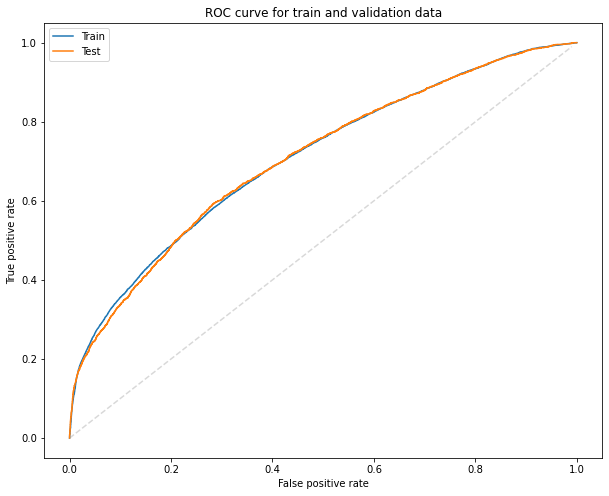

In [52]:
#CODE FOR CREATING ROC PLOT
#get ROCs for the training and test data
yhat_train = logit.predict_proba(X_train[predictors])[:,1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, yhat_train)
yhat_val = logit.predict_proba(X_val[predictors])[:,1]
fpr_val, tpr_val, thresholds_test = roc_curve(y_val.values, yhat_val)

#write the plot 
plt.figure(figsize=(10,8))

x = np.arange(0,100)/100
plt.plot(x, x, "--", color = "gray", alpha = 0.3)
plt.plot(fpr_train, tpr_train, label = "Train")
plt.plot(fpr_val, tpr_val, label = "Test")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.title('ROC curve for train and validation data')
plt.legend()
plt.show()

# Bagging 

After running the logistic model, we are interested in whether other models can outperform both the baseline and the logit. The first model we test is a decision tree. To find the best depth of the tree, we test a variety of decision-tree depths in a bagging model in the training and validation data; we then use the depth that produces the highest accuracy score in the validation data as the "best depth" for the decision tree.  

Somewhat interestingly, we find that the decision-tree model actually underperforms the logistic model, though it outperforms the baseline. 

In [53]:
#build bagging decision tree classifier to find best max_depth for random forest
max_depths = np.arange(1,30,1).tolist()
acc_scores = []
#loop over depths
for depth in max_depths:
    #initialize decision tree classifier and bagging
    basemodel = DecisionTreeClassifier(max_depth = depth, random_state = 144)
    bagging = BaggingClassifier(base_estimator = basemodel)
    bagging.fit(X_train[predictors], y_train)
    #get validation accuracy
    val_pred = bagging.predict(X_val[predictors])
    val_acc = accuracy_score(y_val, val_pred)
    acc_scores.append(val_acc)
    


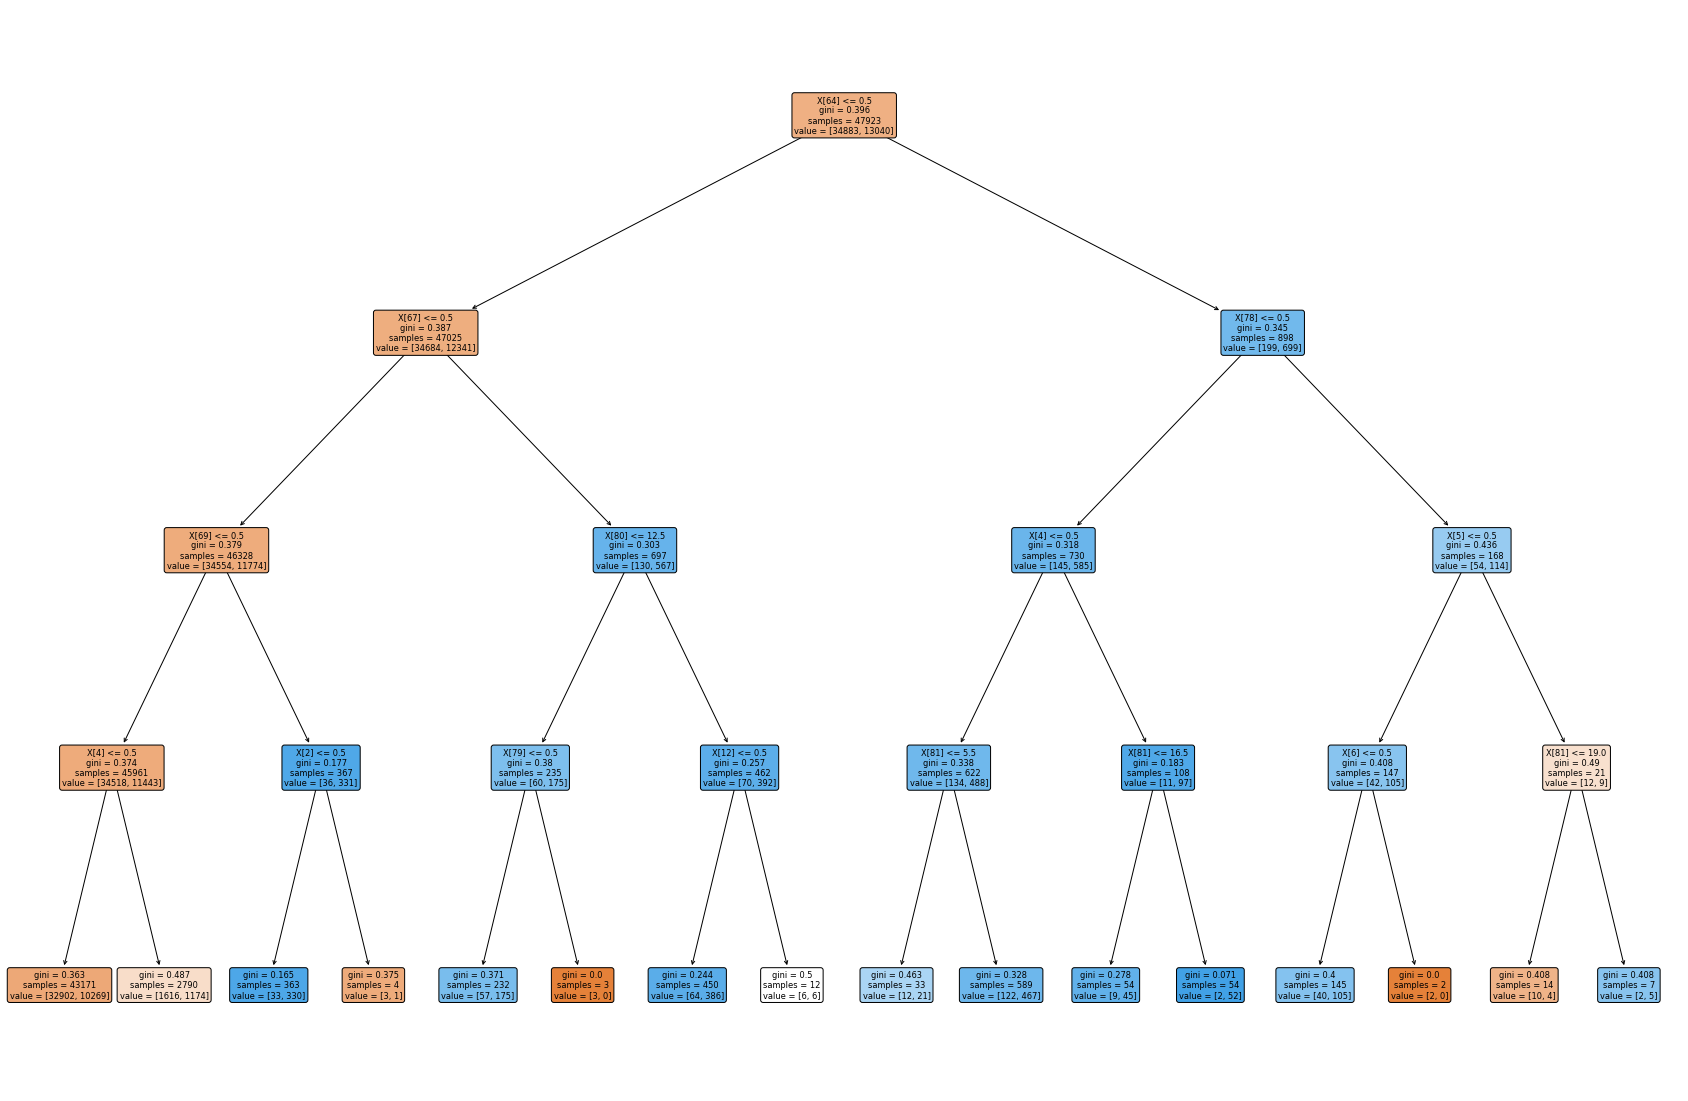

In [61]:
best_depth = max_depths[acc_scores.index(max(acc_scores))]
max(acc_scores)

#visualize the decision tree with the best depth
dtmod = DecisionTreeClassifier(
    max_depth = 4, random_state = 144).fit(X_train[predictors], y_train)
plt.figure(figsize=(30,20))

# Plot the Decision Tree trained above with parameters filled as True
tree.plot_tree(dtmod, filled = True, rounded = True)

plt.show();

# Random forest classifier

Our exploration of different models continues with a random forest classifier. How does this perform relative to the baseline model, the logistic model, and the decision tree? For the trees, we use the depth which produced the highest accuracy score in the bagging model above. TKTKTK STUFF ABOUT HOW WELL THE MODEL PERFORMS 

In [56]:
#BUILD RANDOM FOREST CLASSIFIER using best depth from above
#  and set the maximum depth to be max_depth and use 100 estimators
random_forest = RandomForestClassifier(random_state = 144, max_depth = best_depth, n_estimators = 500)

# Fit the model on the training set
random_forest.fit(X_train[predictors], y_train)

rf_preds = random_forest.predict(X_val[predictors])

rf_acc_val = accuracy_score(y_val, rf_preds)

print("RF accuracy = ", str(rf_acc_val))
print("Bagging accuracy = ", str(round(max(acc_scores), 4)))

#both of these are lower than the logit accuracy!

RF accuracy =  0.754690525472391
Bagging accuracy =  0.7556


In [66]:
#BUILD GRADIENT BOOSTING CLASSIFIER
boosted_model  = GradientBoostingRegressor(n_estimators = 1000, max_depth = 1, learning_rate  = 0.01)
boosted_model.fit(X_train[predictors], y_train)
gb_preds = boosted_model.predict(X_val[predictors])
#gb_acc_val = accuracy_score(y_val, gb_preds)
#print("Gradient boosting validation accuracy = ", str(round(gb_acc_val, 3)))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

# Adaboost Classifier

We look as well at the performance of an AdaBoost classifier, using the same depth as above and using 9 estimators. TKTKTK MATERIAL ABOUT HOW WELL IT PERFORMS. 

In [81]:
#MAKE ADABOOST CLASSIFIER
y_val_ada = np.where(y_val.values == 0, -1, 1)
y_train_ada = np.where(y_train.values == 0, -1, 1)
#use best depth from above
boost = AdaBoostClassifier( base_estimator = DecisionTreeClassifier(max_depth = best_depth), 
                            algorithm = 'SAMME', n_estimators=9)
boost.fit(X_train[predictors], y_train)
ada_preds = boost.predict(X_val[predictors])
ada_acc = accuracy_score(ada_preds, y_val)
print("AdaBoost accuracy in validation = ", str(round(ada_acc, 3)))
#this is also lower than the logit accuracy! 

if ada_acc < acc_val: 
    print("Logit beats adaboost for validation accuracy!")

AdaBoost accuracy in validation =  0.755
Logit beats adaboost for validation accuracy!
